In [1]:
import torch
import torchvision.transforms as TF
import os
import matplotlib.pyplot as plt
from PIL import Image

from model.model_utils import load_weights, create_model, decode_prediction
from tools.visualization import DetectionVisualization


# Load Model & set it to Inference mode

In [2]:
checkpoint_path = './pre-trained-models/ctdet_pascal_resdcn18_384.pth'
model = create_model('resnet18', 64)
load_weights(model, checkpoint_path)
model = model.cuda()
model.eval()

Loaded weights from ./pre-trained-models/ctdet_pascal_resdcn18_384.pth


Sequential(
  (backbone): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2_1): BasicLayer(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2_2): BasicLayer(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

# Create model's input

In [3]:
def create_input(image_files, transform):
    batch_ims = list()
    for file in image_files:
        im = Image.open(file)
        batch_ims.append(transform(im).unsqueeze(0))  # (1, 3, 384, 384)
        
    return torch.cat(batch_ims, dim=0)

In [4]:
transform_input = TF.Compose([
    TF.Resize(size=(384, 384)),
    TF.ToTensor(),
    TF.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [5]:
image_dir = '/home/user/dataset/pascal-voc/VOC2007/JPEGImages'
image_names = ['000009', '000013', '000015', '000039']
image_names = [os.path.join(image_dir, "{}.jpg".format(name)) for name in image_names]

In [6]:
net_input = create_input(image_names, transform_input)
net_input = net_input.cuda()

with torch.no_grad():
    pred = model(net_input).cpu()
    # activate heatmap
    pred[:, :20] = torch.sigmoid(pred[:, :20])
    
print('pred.size: ', pred.size())
del net_input  # to save gpu memory

pred.size:  torch.Size([4, 24, 96, 96])


---
# Visualize detection

In [7]:
visualizer = DetectionVisualization()

## Heatmap

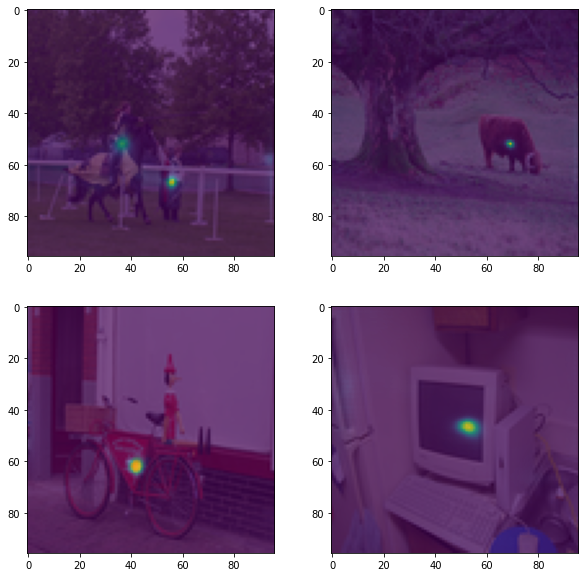

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
visualizer.draw_images(image_names, axes)
visualizer.draw_heatmap(pred[:, :20], axes, ['person', 'cow', 'bicycle','tvmonitor'])

## draw_prediction

In [9]:
batch_boxes = decode_prediction(pred)

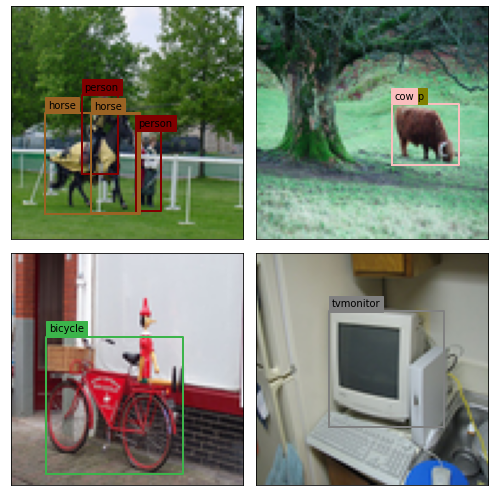

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
visualizer.draw_images(image_names, axes)
visualizer.draw_prediction(batch_boxes, axes)

for r in range(2):
    for c in range(2):
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])

fig.tight_layout()

In [11]:
del model